In [1]:
from sys import path
path.append('..')
path.append('../../src/')

import os
import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import random as rn
import tensorflow as tf
from os.path import basename, join

import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Lambda, Reshape
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, GlobalAvgPool2D
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

from skmultilearn.model_selection import iterative_train_test_split

from tensorflow.contrib.tensorboard.plugins import projector

from global_config import RANDOM_SEED, IMAGE_SIZE, FILE_DUMP_IMAGES, FILE_DUMP_MRKS
from local_config import FOLDER_MODELS, FILE_AUTOENCODER_SAMPLES
from custom_metrics import precision, recall, f1, specificity, fbeta
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from utils import plot, load

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
PATH_TO_ROOT = '../../'

FOLDER_LOGS = join(PATH_TO_ROOT, 'logs')
FOLDER_MODELS = join(PATH_TO_ROOT, FOLDER_MODELS)
FILE_DUMP_MRKS = join(PATH_TO_ROOT, FILE_DUMP_MRKS)
FILE_DUMP_IMAGES = join(PATH_TO_ROOT, FILE_DUMP_IMAGES)
FILE_AUTOENCODER_SAMPLES = join(PATH_TO_ROOT, FILE_AUTOENCODER_SAMPLES)

print(FOLDER_LOGS)
print(FOLDER_MODELS)
print(FILE_DUMP_MRKS)
print(FILE_DUMP_IMAGES)
print(FILE_AUTOENCODER_SAMPLES)

../../logs
../../models/unsupervised_supervised/
../../data/cropped_faces/cropped_faces_mrks.pkl
../../data/cropped_faces/cropped_faces_images.pkl
../../data/unsupervised_supervised_samples.pkl


In [3]:
TEST_SIZE = 0.1
MLFLOW_EXPERIMENT_NAME = 'Unsupervised + Supervised'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)

# Data Loading 

In [5]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))
y = np.array([mrk_file.photo_reqs.values() for mrk_file in mrks])

print(x.shape, x.dtype)
print(y.shape, y.dtype)
print(len(mrks))

(5731, 160, 160, 3) float32
(5731, 23) int32
5731


In [6]:
np.random.seed(RANDOM_SEED)
x_train_idx, y_train, x_val_idx, y_val = iterative_train_test_split(np.arange(x.shape[0]).reshape(-1, 1), y, test_size=TEST_SIZE)
x_train_idx = x_train_idx.ravel()
x_val_idx = x_val_idx.ravel()

x_train = x[x_train_idx]
x_val = x[x_val_idx]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(5151, 160, 160, 3) (5151, 23)
(580, 160, 160, 3) (580, 23)


In [7]:
train_mrks = mrks[x_train_idx]
val_mrks = mrks[x_val_idx]

# pkl.dump((x_train, x_val, train_mrks, val_mrks), open(FILE_AUTOENCODER_SAMPLES, 'wb'), -1)

# Model Training 

In [8]:
x_train, x_val, _, _ = pkl.load(open(FILE_AUTOENCODER_SAMPLES, 'rb'))
x_train /= 255.0
x_val /= 255.0

print(x_train.shape, x_train.dtype, x_train.min(), x_train.max())
print(x_val.shape, x_val.dtype, x_val.min(), x_val.max())

(5151, 160, 160, 3) float32 0.0 1.0
(580, 160, 160, 3) float32 0.0 1.0


In [9]:
img_height, img_width = IMAGE_SIZE

def sample_z(args):
    mu, sigma = args
    batch_size = K.shape(mu)[0]
    latent_dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch_size, latent_dim))
    return mu + K.exp(0.5 * sigma) * eps


def vae_loss(y_true, y_pred):
    """
    https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder_deconv.py
    https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/
    """
    reconstruction_loss = binary_crossentropy(K.flatten(y_true), K.flatten(y_pred))
    reconstruction_loss *= (img_width * img_height)
    
    kl_loss = 1 + z_sigma - K.square(z_mean) - K.exp(z_sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)


# def vae_loss(y_true, y_pred):
#     """https://keras.io/examples/generative/vae/#define-the-vae-as-a-model-with-a-custom-trainstep""""
#     reconstruction_loss = tf.reduce_mean(binary_crossentropy(y_true, y_pred))
#     reconstruction_loss *= (img_width * img_height)
    
#     kl_loss = 1 + z_sigma - tf.square(z_mean) - tf.exp(z_sigma)
#     kl_loss = tf.reduce_mean(kl_loss)
#     kl_loss *= -0.5
#     return reconstruction_loss + kl_loss

In [10]:
def conv_bn(idx, prev_input, filters, activation='relu', name=None):
    conv_name = 'conv_' + str(idx)
    bn_name = 'bn_' + str(idx)
    act_name = f'{activation}_' + str(idx) if name is None else name
    
    conv = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None, name=conv_name)(prev_input)
    conv = BatchNormalization(axis=-1, name=bn_name)(conv)
    conv = Activation(activation, name=act_name)(conv)
    return conv


def conv_bn_maxpool(idx, prev_input, filters):
    pool_name = 'pool_' + str(idx)
    
    conv = conv_bn(idx, prev_input, filters)
    pool = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name=pool_name)(conv)
    return pool


def deconv_bn(idx, prev_input, filters, activation='relu'):
    bn_name = str(idx) + '_bn' 
    act_name = str(idx) + '_relu' 
    conv_name = str(idx) + '_conv' 
    
    deconv = Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='same', activation=None, name=conv_name)(prev_input)
    deconv = BatchNormalization(axis=-1, name=bn_name)(deconv)
    deconv = Activation(activation, name=act_name)(deconv)
    return deconv


def dense_layer(idx, prev_input, units, dropout=True, rate=0.5, activation='relu'):
    dense_name = f"dense_{idx}"
    drop_name = f"dropout_{idx}"
    
    if dropout:
        prev_input = Dropout(rate, name=drop_name)(prev_input)
    out = Dense(units, activation=activation, name=dense_name)(prev_input)
    return out

In [11]:
set_random_seeds()
LATENT_DIM = 64
N_REQS = y_train.shape[1]

mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("seed", RANDOM_SEED)
mlflow.log_param("latent_dim", LATENT_DIM)
mlflow.keras.autolog()

# encoder
inputs = Input(shape=x_train.shape[1:], name='input')
pool_1 = conv_bn_maxpool(1, inputs, 16)
pool_2 = conv_bn_maxpool(2, pool_1, 32)
pool_3 = conv_bn_maxpool(3, pool_2, 64)
pool_4 = conv_bn_maxpool(4, pool_3, 128)
conv_shape = K.int_shape(pool_4)

avg_pool = GlobalAvgPool2D(name='global_avg_pool')(pool_4)
z_mean = Dense(LATENT_DIM, name='z_mean')(avg_pool)
z_sigma = Dense(LATENT_DIM, name='z_sigma')(avg_pool)
z = Lambda(sample_z, output_shape=(LATENT_DIM, ), name='embeddings')([z_mean, z_sigma])

# decoder
dense = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu', name='dense')(z)
reshape = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name='reshape')(dense)
dec_4 = deconv_bn(4, reshape, 128)
dec_3 = deconv_bn(3, dec_4, 64)
dec_2 = deconv_bn(2, dec_3, 32)
dec_1 = deconv_bn(1, dec_2, 16)
decoded = Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='sigmoid', name='decoded')(dec_1)

# classifier
dense_1 = dense_layer(1, z_mean, 32)
classif = Dense(units=N_REQS, activation='sigmoid', name='outputs')(dense_1)

model = Model(inputs=inputs, outputs=[decoded, classif], name='ICAOnet')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Model: "ICAOnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 16) 0           bn_1[0][0]                       
____________________________________________________________________________________________

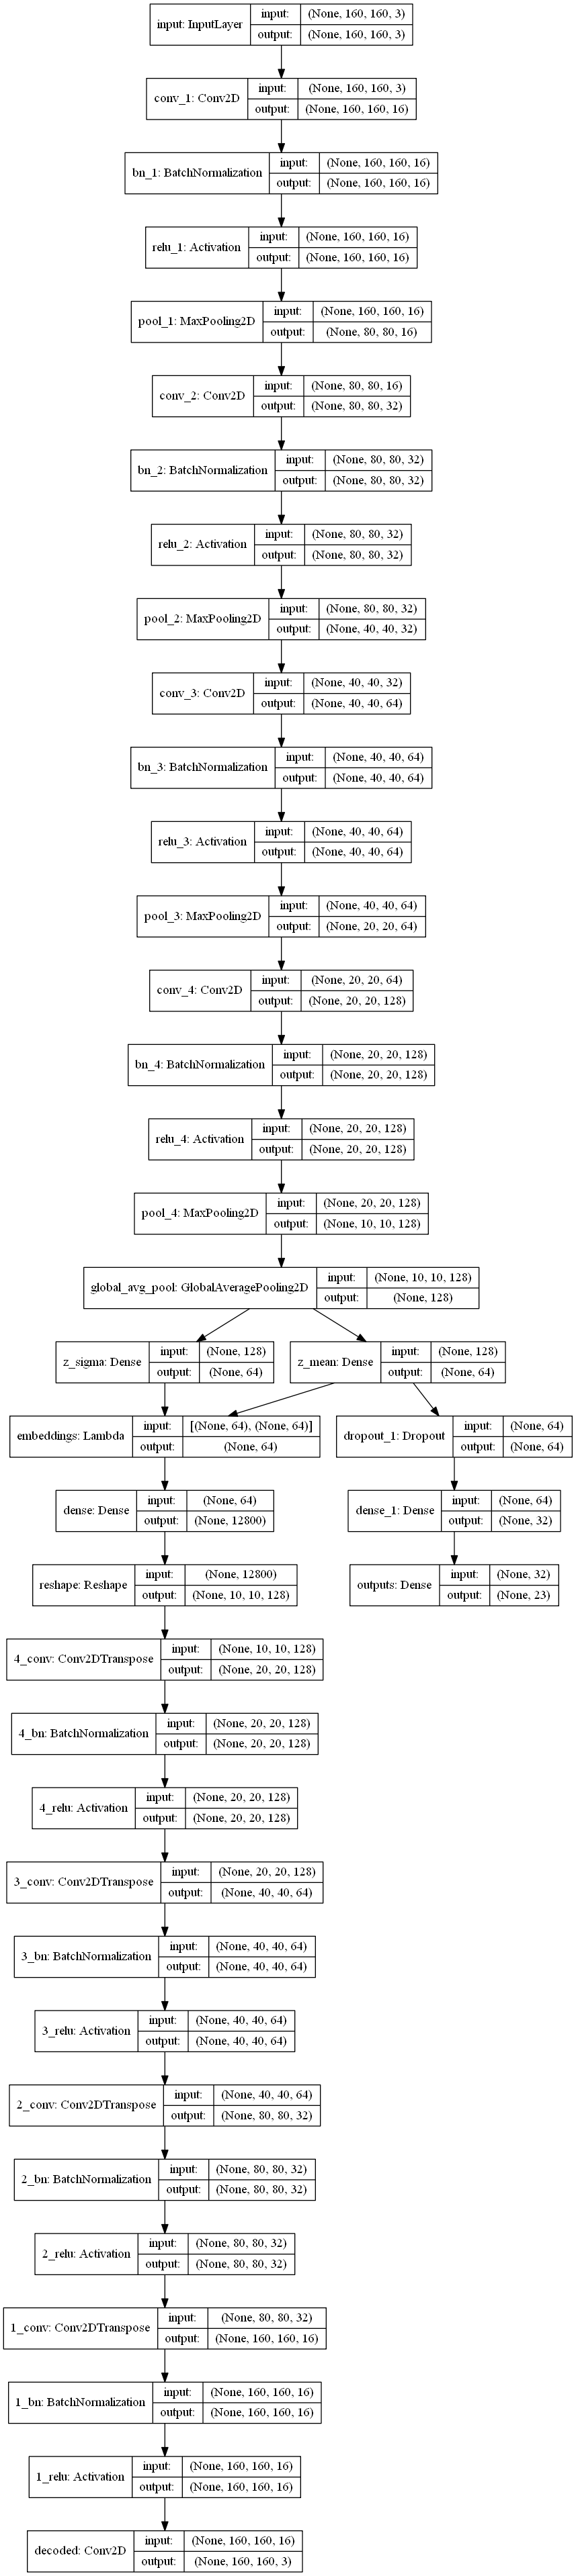

In [12]:
plot_model(model, show_shapes=True)

Instructions for updating:
Use tf.cast instead.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 5151 samples, validate on 580 samples
Epoch 1/200
5151/5151 [==============================] - 34s 7ms/step - loss: 7685.9293 - decoded_loss: 15371.0361 - outputs_loss: 0.5685 - outputs_accuracy: 0.7158 - outputs_precision: 0.8265 - outputs_recall: 0.8161 - outputs_f1: 0.8157 - outputs_fbeta: 0.8133 - outputs_specificity: 0.3196 - outputs_negative_predictive_value: 0.3440 - outputs_matthews_correlation_coefficient: 0.1494 - val_loss: 7834.9264 - val_decoded_loss: 15736.8984 - val_outputs_loss: 0.5134 - val_outputs_accuracy: 0.7720 - val_outputs_precision: 0.8078 - val_outputs_recall: 0.9174 - val_outputs_f1: 0.8578 - val_outputs_fbeta: 0.8896 - val_outputs_specificity: 0.2350 - val_outputs_negative_predictive_value: 0.4464 - val_outputs_matthews_correlation_coefficient: 0.1962

Epoch 00001: val_outputs_fbeta improved from -inf to 0.88957, saving model to ../../models/unsupervised_supervised/multilearner_2020_07_18-22_53_52.h5
Epoch 2/200
5151/5151 [============================

5151/5151 [==============================] - 29s 6ms/step - loss: 6506.2195 - decoded_loss: 13011.9883 - outputs_loss: 0.3632 - outputs_accuracy: 0.8282 - outputs_precision: 0.8508 - outputs_recall: 0.9520 - outputs_f1: 0.8984 - outputs_fbeta: 0.9267 - outputs_specificity: 0.3381 - outputs_negative_predictive_value: 0.6386 - outputs_matthews_correlation_coefficient: 0.3764 - val_loss: 4659.1831 - val_decoded_loss: 9592.4521 - val_outputs_loss: 0.3385 - val_outputs_accuracy: 0.8478 - val_outputs_precision: 0.8590 - val_outputs_recall: 0.9504 - val_outputs_f1: 0.9008 - val_outputs_fbeta: 0.9277 - val_outputs_specificity: 0.4643 - val_outputs_negative_predictive_value: 0.7179 - val_outputs_matthews_correlation_coefficient: 0.4878

Epoch 00010: val_outputs_fbeta did not improve from 0.94034
Epoch 11/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6483.3772 - decoded_loss: 12966.2129 - outputs_loss: 0.3607 - outputs_accuracy: 0.8305 - outputs_precision: 0.8508 - output

5151/5151 [==============================] - 29s 6ms/step - loss: 6382.9108 - decoded_loss: 12765.4941 - outputs_loss: 0.3507 - outputs_accuracy: 0.8358 - outputs_precision: 0.8570 - outputs_recall: 0.9536 - outputs_f1: 0.9026 - outputs_fbeta: 0.9296 - outputs_specificity: 0.3691 - outputs_negative_predictive_value: 0.6652 - outputs_matthews_correlation_coefficient: 0.4099 - val_loss: 3864.9629 - val_decoded_loss: 8065.4102 - val_outputs_loss: 0.3103 - val_outputs_accuracy: 0.8673 - val_outputs_precision: 0.8731 - val_outputs_recall: 0.9543 - val_outputs_f1: 0.9108 - val_outputs_fbeta: 0.9356 - val_outputs_specificity: 0.5291 - val_outputs_negative_predictive_value: 0.7623 - val_outputs_matthews_correlation_coefficient: 0.5537

Epoch 00020: val_outputs_fbeta did not improve from 0.94160
Epoch 21/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6392.2291 - decoded_loss: 12784.2910 - outputs_loss: 0.3487 - outputs_accuracy: 0.8368 - outputs_precision: 0.8567 - output

5151/5151 [==============================] - 29s 6ms/step - loss: 6325.1637 - decoded_loss: 12649.8740 - outputs_loss: 0.3428 - outputs_accuracy: 0.8401 - outputs_precision: 0.8604 - outputs_recall: 0.9547 - outputs_f1: 0.9049 - outputs_fbeta: 0.9314 - outputs_specificity: 0.3860 - outputs_negative_predictive_value: 0.6810 - outputs_matthews_correlation_coefficient: 0.4290 - val_loss: 3849.2426 - val_decoded_loss: 8032.8618 - val_outputs_loss: 0.2978 - val_outputs_accuracy: 0.8733 - val_outputs_precision: 0.8765 - val_outputs_recall: 0.9604 - val_outputs_f1: 0.9153 - val_outputs_fbeta: 0.9405 - val_outputs_specificity: 0.5438 - val_outputs_negative_predictive_value: 0.7890 - val_outputs_matthews_correlation_coefficient: 0.5785

Epoch 00030: val_outputs_fbeta did not improve from 0.94160
Epoch 31/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6310.0789 - decoded_loss: 12619.7441 - outputs_loss: 0.3429 - outputs_accuracy: 0.8408 - outputs_precision: 0.8608 - output


Epoch 00039: val_outputs_fbeta did not improve from 0.94656
Epoch 40/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6270.4385 - decoded_loss: 12540.3887 - outputs_loss: 0.3382 - outputs_accuracy: 0.8424 - outputs_precision: 0.8635 - outputs_recall: 0.9536 - outputs_f1: 0.9062 - outputs_fbeta: 0.9312 - outputs_specificity: 0.4024 - outputs_negative_predictive_value: 0.6852 - outputs_matthews_correlation_coefficient: 0.4414 - val_loss: 3831.1578 - val_decoded_loss: 7993.6973 - val_outputs_loss: 0.2872 - val_outputs_accuracy: 0.8879 - val_outputs_precision: 0.8891 - val_outputs_recall: 0.9628 - val_outputs_f1: 0.9227 - val_outputs_fbeta: 0.9450 - val_outputs_specificity: 0.6024 - val_outputs_negative_predictive_value: 0.8155 - val_outputs_matthews_correlation_coefficient: 0.6291

Epoch 00040: val_outputs_fbeta did not improve from 0.94656
Epoch 41/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6271.5463 - decoded_loss: 12542.6826 - outputs_lo


Epoch 00049: val_outputs_fbeta did not improve from 0.94690
Epoch 50/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6251.1950 - decoded_loss: 12501.8477 - outputs_loss: 0.3369 - outputs_accuracy: 0.8446 - outputs_precision: 0.8668 - outputs_recall: 0.9517 - outputs_f1: 0.9071 - outputs_fbeta: 0.9305 - outputs_specificity: 0.4206 - outputs_negative_predictive_value: 0.6869 - outputs_matthews_correlation_coefficient: 0.4534 - val_loss: 3815.3608 - val_decoded_loss: 7964.8164 - val_outputs_loss: 0.2873 - val_outputs_accuracy: 0.8878 - val_outputs_precision: 0.8908 - val_outputs_recall: 0.9630 - val_outputs_f1: 0.9241 - val_outputs_fbeta: 0.9462 - val_outputs_specificity: 0.6066 - val_outputs_negative_predictive_value: 0.8188 - val_outputs_matthews_correlation_coefficient: 0.6346

Epoch 00050: val_outputs_fbeta did not improve from 0.94690
Epoch 51/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6241.5549 - decoded_loss: 12482.7275 - outputs_lo


Epoch 00059: val_outputs_fbeta did not improve from 0.94769
Epoch 60/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6226.2856 - decoded_loss: 12452.1943 - outputs_loss: 0.3336 - outputs_accuracy: 0.8461 - outputs_precision: 0.8682 - outputs_recall: 0.9520 - outputs_f1: 0.9080 - outputs_fbeta: 0.9312 - outputs_specificity: 0.4268 - outputs_negative_predictive_value: 0.6904 - outputs_matthews_correlation_coefficient: 0.4593 - val_loss: 3795.2228 - val_decoded_loss: 7922.7646 - val_outputs_loss: 0.2742 - val_outputs_accuracy: 0.8859 - val_outputs_precision: 0.8981 - val_outputs_recall: 0.9493 - val_outputs_f1: 0.9211 - val_outputs_fbeta: 0.9368 - val_outputs_specificity: 0.6471 - val_outputs_negative_predictive_value: 0.7772 - val_outputs_matthews_correlation_coefficient: 0.6327

Epoch 00060: val_outputs_fbeta did not improve from 0.94769
Epoch 61/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6215.3472 - decoded_loss: 12430.2939 - outputs_lo


Epoch 00069: val_outputs_fbeta did not improve from 0.94915
Epoch 70/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6197.2963 - decoded_loss: 12394.2939 - outputs_loss: 0.3323 - outputs_accuracy: 0.8475 - outputs_precision: 0.8686 - outputs_recall: 0.9534 - outputs_f1: 0.9089 - outputs_fbeta: 0.9323 - outputs_specificity: 0.4274 - outputs_negative_predictive_value: 0.6968 - outputs_matthews_correlation_coefficient: 0.4634 - val_loss: 3710.1267 - val_decoded_loss: 7764.2617 - val_outputs_loss: 0.2743 - val_outputs_accuracy: 0.8863 - val_outputs_precision: 0.8901 - val_outputs_recall: 0.9596 - val_outputs_f1: 0.9220 - val_outputs_fbeta: 0.9429 - val_outputs_specificity: 0.6068 - val_outputs_negative_predictive_value: 0.8039 - val_outputs_matthews_correlation_coefficient: 0.6255

Epoch 00070: val_outputs_fbeta did not improve from 0.94915
Epoch 71/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6200.1372 - decoded_loss: 12399.9326 - outputs_lo

5151/5151 [==============================] - 29s 6ms/step - loss: 6174.4788 - decoded_loss: 12348.8584 - outputs_loss: 0.3297 - outputs_accuracy: 0.8478 - outputs_precision: 0.8690 - outputs_recall: 0.9532 - outputs_f1: 0.9090 - outputs_fbeta: 0.9323 - outputs_specificity: 0.4305 - outputs_negative_predictive_value: 0.6969 - outputs_matthews_correlation_coefficient: 0.4655 - val_loss: 3675.4259 - val_decoded_loss: 7696.0117 - val_outputs_loss: 0.2659 - val_outputs_accuracy: 0.8999 - val_outputs_precision: 0.9036 - val_outputs_recall: 0.9638 - val_outputs_f1: 0.9310 - val_outputs_fbeta: 0.9495 - val_outputs_specificity: 0.6649 - val_outputs_negative_predictive_value: 0.8347 - val_outputs_matthews_correlation_coefficient: 0.6793

Epoch 00080: val_outputs_fbeta improved from 0.94915 to 0.94947, saving model to ../../models/unsupervised_supervised/multilearner_2020_07_18-22_53_52.h5
Epoch 81/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6177.8910 - decoded_loss: 123


Epoch 00089: val_outputs_fbeta did not improve from 0.95160
Epoch 90/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6159.6709 - decoded_loss: 12318.9795 - outputs_loss: 0.3281 - outputs_accuracy: 0.8483 - outputs_precision: 0.8699 - outputs_recall: 0.9526 - outputs_f1: 0.9092 - outputs_fbeta: 0.9320 - outputs_specificity: 0.4354 - outputs_negative_predictive_value: 0.6971 - outputs_matthews_correlation_coefficient: 0.4686 - val_loss: 3682.6976 - val_decoded_loss: 7707.4399 - val_outputs_loss: 0.2662 - val_outputs_accuracy: 0.8963 - val_outputs_precision: 0.8980 - val_outputs_recall: 0.9640 - val_outputs_f1: 0.9281 - val_outputs_fbeta: 0.9483 - val_outputs_specificity: 0.6417 - val_outputs_negative_predictive_value: 0.8289 - val_outputs_matthews_correlation_coefficient: 0.6616

Epoch 00090: val_outputs_fbeta did not improve from 0.95160
Epoch 91/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6169.7856 - decoded_loss: 12339.2148 - outputs_lo


Epoch 00099: val_outputs_fbeta did not improve from 0.95313
Epoch 100/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6149.6178 - decoded_loss: 12298.9521 - outputs_loss: 0.3276 - outputs_accuracy: 0.8503 - outputs_precision: 0.8717 - outputs_recall: 0.9528 - outputs_f1: 0.9103 - outputs_fbeta: 0.9326 - outputs_specificity: 0.4440 - outputs_negative_predictive_value: 0.7030 - outputs_matthews_correlation_coefficient: 0.4769 - val_loss: 3749.9849 - val_decoded_loss: 7835.9521 - val_outputs_loss: 0.2696 - val_outputs_accuracy: 0.8971 - val_outputs_precision: 0.9132 - val_outputs_recall: 0.9467 - val_outputs_f1: 0.9273 - val_outputs_fbeta: 0.9389 - val_outputs_specificity: 0.7157 - val_outputs_negative_predictive_value: 0.7853 - val_outputs_matthews_correlation_coefficient: 0.6772

Epoch 00100: val_outputs_fbeta did not improve from 0.95313
Epoch 101/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6148.5133 - decoded_loss: 12296.5850 - outputs_

5151/5151 [==============================] - 29s 6ms/step - loss: 6137.8702 - decoded_loss: 12275.4053 - outputs_loss: 0.3262 - outputs_accuracy: 0.8509 - outputs_precision: 0.8717 - outputs_recall: 0.9537 - outputs_f1: 0.9108 - outputs_fbeta: 0.9332 - outputs_specificity: 0.4426 - outputs_negative_predictive_value: 0.7059 - outputs_matthews_correlation_coefficient: 0.4779 - val_loss: 3728.6930 - val_decoded_loss: 7797.2690 - val_outputs_loss: 0.2652 - val_outputs_accuracy: 0.8961 - val_outputs_precision: 0.8964 - val_outputs_recall: 0.9638 - val_outputs_f1: 0.9275 - val_outputs_fbeta: 0.9479 - val_outputs_specificity: 0.6353 - val_outputs_negative_predictive_value: 0.8281 - val_outputs_matthews_correlation_coefficient: 0.6575

Epoch 00110: val_outputs_fbeta did not improve from 0.95313
Epoch 111/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6137.5771 - decoded_loss: 12275.0156 - outputs_loss: 0.3254 - outputs_accuracy: 0.8498 - outputs_precision: 0.8718 - outpu


Epoch 00119: val_outputs_fbeta improved from 0.95407 to 0.95477, saving model to ../../models/unsupervised_supervised/multilearner_2020_07_18-22_53_52.h5
Epoch 120/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6133.4293 - decoded_loss: 12266.6338 - outputs_loss: 0.3256 - outputs_accuracy: 0.8521 - outputs_precision: 0.8740 - outputs_recall: 0.9522 - outputs_f1: 0.9113 - outputs_fbeta: 0.9326 - outputs_specificity: 0.4550 - outputs_negative_predictive_value: 0.7048 - outputs_matthews_correlation_coefficient: 0.4849 - val_loss: 3741.2231 - val_decoded_loss: 7822.8413 - val_outputs_loss: 0.2583 - val_outputs_accuracy: 0.9037 - val_outputs_precision: 0.9081 - val_outputs_recall: 0.9621 - val_outputs_f1: 0.9327 - val_outputs_fbeta: 0.9494 - val_outputs_specificity: 0.6857 - val_outputs_negative_predictive_value: 0.8320 - val_outputs_matthews_correlation_coefficient: 0.6908

Epoch 00120: val_outputs_fbeta did not improve from 0.95477
Epoch 121/200
5151/5151 [========


Epoch 00129: val_outputs_fbeta did not improve from 0.95477
Epoch 130/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6122.0110 - decoded_loss: 12243.6963 - outputs_loss: 0.3266 - outputs_accuracy: 0.8501 - outputs_precision: 0.8720 - outputs_recall: 0.9522 - outputs_f1: 0.9102 - outputs_fbeta: 0.9320 - outputs_specificity: 0.4458 - outputs_negative_predictive_value: 0.7012 - outputs_matthews_correlation_coefficient: 0.4770 - val_loss: 3728.1487 - val_decoded_loss: 7793.1812 - val_outputs_loss: 0.2577 - val_outputs_accuracy: 0.8980 - val_outputs_precision: 0.8939 - val_outputs_recall: 0.9718 - val_outputs_f1: 0.9297 - val_outputs_fbeta: 0.9531 - val_outputs_specificity: 0.6197 - val_outputs_negative_predictive_value: 0.8570 - val_outputs_matthews_correlation_coefficient: 0.6649

Epoch 00130: val_outputs_fbeta did not improve from 0.95477
Epoch 131/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6121.5178 - decoded_loss: 12242.7080 - outputs_

5151/5151 [==============================] - 29s 6ms/step - loss: 6115.6742 - decoded_loss: 12230.9961 - outputs_loss: 0.3233 - outputs_accuracy: 0.8518 - outputs_precision: 0.8728 - outputs_recall: 0.9534 - outputs_f1: 0.9112 - outputs_fbeta: 0.9332 - outputs_specificity: 0.4493 - outputs_negative_predictive_value: 0.7097 - outputs_matthews_correlation_coefficient: 0.4838 - val_loss: 3696.7095 - val_decoded_loss: 7730.3652 - val_outputs_loss: 0.2635 - val_outputs_accuracy: 0.8995 - val_outputs_precision: 0.8957 - val_outputs_recall: 0.9691 - val_outputs_f1: 0.9296 - val_outputs_fbeta: 0.9515 - val_outputs_specificity: 0.6290 - val_outputs_negative_predictive_value: 0.8484 - val_outputs_matthews_correlation_coefficient: 0.6660

Epoch 00140: val_outputs_fbeta did not improve from 0.95477
Epoch 141/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6127.7079 - decoded_loss: 12255.0371 - outputs_loss: 0.3243 - outputs_accuracy: 0.8515 - outputs_precision: 0.8737 - outpu

5151/5151 [==============================] - 29s 6ms/step - loss: 6109.7233 - decoded_loss: 12219.1875 - outputs_loss: 0.3251 - outputs_accuracy: 0.8512 - outputs_precision: 0.8720 - outputs_recall: 0.9540 - outputs_f1: 0.9110 - outputs_fbeta: 0.9334 - outputs_specificity: 0.4444 - outputs_negative_predictive_value: 0.7084 - outputs_matthews_correlation_coefficient: 0.4801 - val_loss: 3705.0372 - val_decoded_loss: 7750.8477 - val_outputs_loss: 0.2543 - val_outputs_accuracy: 0.9034 - val_outputs_precision: 0.9028 - val_outputs_recall: 0.9665 - val_outputs_f1: 0.9320 - val_outputs_fbeta: 0.9515 - val_outputs_specificity: 0.6644 - val_outputs_negative_predictive_value: 0.8447 - val_outputs_matthews_correlation_coefficient: 0.6853

Epoch 00150: val_outputs_fbeta did not improve from 0.95715
Epoch 151/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6109.2417 - decoded_loss: 12218.2451 - outputs_loss: 0.3240 - outputs_accuracy: 0.8514 - outputs_precision: 0.8730 - outpu

5151/5151 [==============================] - 29s 6ms/step - loss: 6102.8277 - decoded_loss: 12205.3496 - outputs_loss: 0.3228 - outputs_accuracy: 0.8523 - outputs_precision: 0.8739 - outputs_recall: 0.9527 - outputs_f1: 0.9115 - outputs_fbeta: 0.9329 - outputs_specificity: 0.4543 - outputs_negative_predictive_value: 0.7077 - outputs_matthews_correlation_coefficient: 0.4859 - val_loss: 3746.8453 - val_decoded_loss: 7830.0063 - val_outputs_loss: 0.2532 - val_outputs_accuracy: 0.9030 - val_outputs_precision: 0.9142 - val_outputs_recall: 0.9545 - val_outputs_f1: 0.9321 - val_outputs_fbeta: 0.9452 - val_outputs_specificity: 0.7147 - val_outputs_negative_predictive_value: 0.8101 - val_outputs_matthews_correlation_coefficient: 0.6943

Epoch 00160: val_outputs_fbeta did not improve from 0.95715
Epoch 161/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6105.0448 - decoded_loss: 12209.9551 - outputs_loss: 0.3232 - outputs_accuracy: 0.8518 - outputs_precision: 0.8733 - outpu

5151/5151 [==============================] - 29s 6ms/step - loss: 6099.3036 - decoded_loss: 12198.3730 - outputs_loss: 0.3226 - outputs_accuracy: 0.8529 - outputs_precision: 0.8746 - outputs_recall: 0.9525 - outputs_f1: 0.9118 - outputs_fbeta: 0.9328 - outputs_specificity: 0.4577 - outputs_negative_predictive_value: 0.7081 - outputs_matthews_correlation_coefficient: 0.4883 - val_loss: 3721.4650 - val_decoded_loss: 7779.8677 - val_outputs_loss: 0.2531 - val_outputs_accuracy: 0.9046 - val_outputs_precision: 0.9091 - val_outputs_recall: 0.9621 - val_outputs_f1: 0.9331 - val_outputs_fbeta: 0.9496 - val_outputs_specificity: 0.6913 - val_outputs_negative_predictive_value: 0.8313 - val_outputs_matthews_correlation_coefficient: 0.6937

Epoch 00170: val_outputs_fbeta did not improve from 0.95715
Epoch 171/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6102.0349 - decoded_loss: 12203.7500 - outputs_loss: 0.3222 - outputs_accuracy: 0.8536 - outputs_precision: 0.8744 - outpu

5151/5151 [==============================] - 29s 6ms/step - loss: 6092.6674 - decoded_loss: 12185.1230 - outputs_loss: 0.3233 - outputs_accuracy: 0.8521 - outputs_precision: 0.8730 - outputs_recall: 0.9534 - outputs_f1: 0.9113 - outputs_fbeta: 0.9333 - outputs_specificity: 0.4495 - outputs_negative_predictive_value: 0.7088 - outputs_matthews_correlation_coefficient: 0.4835 - val_loss: 3712.9931 - val_decoded_loss: 7762.4194 - val_outputs_loss: 0.2525 - val_outputs_accuracy: 0.9030 - val_outputs_precision: 0.8993 - val_outputs_recall: 0.9708 - val_outputs_f1: 0.9323 - val_outputs_fbeta: 0.9540 - val_outputs_specificity: 0.6461 - val_outputs_negative_predictive_value: 0.8594 - val_outputs_matthews_correlation_coefficient: 0.6829

Epoch 00180: val_outputs_fbeta did not improve from 0.95715
Epoch 181/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6097.7463 - decoded_loss: 12195.2627 - outputs_loss: 0.3233 - outputs_accuracy: 0.8526 - outputs_precision: 0.8737 - outpu

5151/5151 [==============================] - 29s 6ms/step - loss: 6088.6034 - decoded_loss: 12176.9219 - outputs_loss: 0.3233 - outputs_accuracy: 0.8521 - outputs_precision: 0.8745 - outputs_recall: 0.9514 - outputs_f1: 0.9112 - outputs_fbeta: 0.9320 - outputs_specificity: 0.4582 - outputs_negative_predictive_value: 0.7037 - outputs_matthews_correlation_coefficient: 0.4860 - val_loss: 3743.3817 - val_decoded_loss: 7823.7573 - val_outputs_loss: 0.2478 - val_outputs_accuracy: 0.9042 - val_outputs_precision: 0.9055 - val_outputs_recall: 0.9673 - val_outputs_f1: 0.9336 - val_outputs_fbeta: 0.9526 - val_outputs_specificity: 0.6727 - val_outputs_negative_predictive_value: 0.8477 - val_outputs_matthews_correlation_coefficient: 0.6923

Epoch 00190: val_outputs_fbeta did not improve from 0.95715
Epoch 191/200
5151/5151 [==============================] - 29s 6ms/step - loss: 6094.1871 - decoded_loss: 12188.0938 - outputs_loss: 0.3220 - outputs_accuracy: 0.8531 - outputs_precision: 0.8749 - outpu

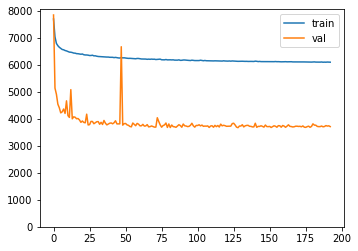

In [13]:
DECODED_LOSS_WEIGHT = 0.5
OUTPUTS_LOSS_WEIGHT = 0.5

mlflow.log_param("decoded loss weight", DECODED_LOSS_WEIGHT)
mlflow.log_param("outputs loss weight", OUTPUTS_LOSS_WEIGHT)

losses = {
    "decoded": vae_loss,
    "outputs": "binary_crossentropy"
}

loss_weights = {
    "decoded": DECODED_LOSS_WEIGHT,
    "outputs": OUTPUTS_LOSS_WEIGHT
}

metrics = {
    "outputs": ["accuracy", precision, recall, f1, fbeta, specificity, npv, mcc]
}
METRIC_TO_MONITOR = "val_outputs_fbeta"

outputs_train = {
    "decoded": x_train,
    "outputs": y_train
}

outputs_valid = {
    "decoded": x_val,
    "outputs": y_val
}

model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=metrics)

FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix="multilearner_")
list_callbacks = [
    ModelCheckpoint(FILE_MODEL, monitor=METRIC_TO_MONITOR, mode="max", verbose=1, save_best_only=True), 
    EarlyStopping(monitor=METRIC_TO_MONITOR, mode="max", patience=50, verbose=1, restore_best_weights=True)
]

hist = model.fit(
    x=x_train,
    y=outputs_train,
    batch_size=32,
    epochs=200,
    validation_data=(x_val, outputs_valid),
    callbacks=list_callbacks
)

plot.keras_hist(hist.history)

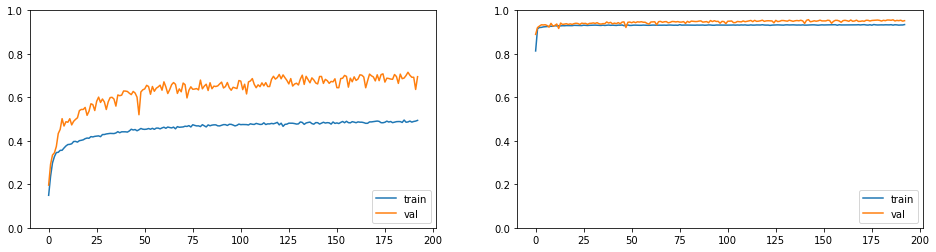

In [14]:
history = hist.history

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(history['outputs_matthews_correlation_coefficient'], label='train')
plt.plot(history['val_outputs_matthews_correlation_coefficient'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history['outputs_fbeta'], label='train')
plt.plot(history['val_outputs_fbeta'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

# Test Model

[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1]
[1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1]


Text(0.5, 1.0, 'decoded image')

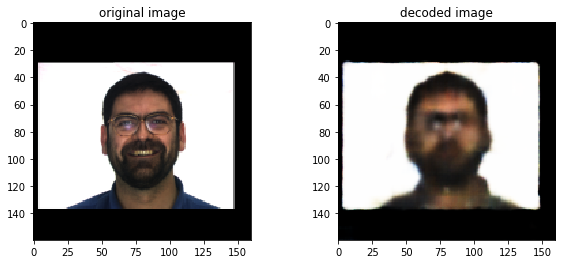

In [18]:
random_idx = np.random.choice(x_val.shape[0])
im = np.expand_dims(x_val[random_idx], axis=0)
y_true = y_val[random_idx] 

y_pred_decoded, y_pred_outputs = model.predict(im)
y_pred_outputs = np.where(y_pred_outputs > 0.5, 1, 0)

print(y_true, y_pred_outputs[0], sep='\n')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(im.squeeze()[:, :, ::-1])
plt.title('original image')

plt.subplot(1, 2, 2)
plt.imshow(y_pred_decoded.squeeze()[:, :, ::-1])
plt.title('decoded image')

# Save Classification Model 

In [16]:
FILE_MODEL_CLF = FILE_MODEL.replace('multilearner', 'model')
print(FILE_MODEL_CLF)

model_clf = Model(inputs=model.inputs, outputs=model.get_layer('outputs').output, name="ICAOnet")
model_clf.summary()

model_clf.save(FILE_MODEL_CLF)

../../models/unsupervised_supervised/model_2020_07_18-22_53_52.h5
Model: "ICAOnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 16)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 32)        4640      
___________________________________________________________

In [17]:
import cv2
from glob import glob

model_clf = load_model(FILE_MODEL_CLF)

list_files = [PATH_TO_ROOT + 'data/cropped_faces/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred_ori = model.predict(im)[1]
y_pred_clf = model_clf.predict(im)
assert(np.allclose(y_pred_ori, y_pred_clf))

for y_pred in y_pred_clf[0]:
    print(y_pred)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


../../data/cropped_faces/images/AR_FDB_m-013-17.png


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '



0.9859779
0.40801945
0.99967104
0.7920358
0.98933065
0.95940983
0.8439826
0.7785021
0.45883107
0.31362304
0.90435505
0.90362537
0.41610318
0.9952329
0.96655834
0.86675096
0.58334184
0.9999948
0.68136805
0.9947674
0.9999703
0.34864852
0.9994367


# Embeddings Visualization 

In [ ]:
FOLDER_LOGS = '../../logs/unsupervised_supervised/'

### Metadata 

In [ ]:
_, image_files = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
_, data, _, mrks = pkl.load(open(FILE_AUTOENCODER_SAMPLES, 'rb'))

image_files = [basename(filepath) for filepath in np.array(image_files)[x_val_idx]]
print(len(image_files))
print(data.shape)

In [ ]:
with open(f'{FOLDER_LOGS}/metadata.tsv', 'w') as metadata_file:
    for file in image_files:
        metadata_file.write(file+'\n')

mlflow.log_artifact(f'{FOLDER_LOGS}/metadata.tsv')

### Image Sprite

In [ ]:
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min_data = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min_data).transpose(3,0,1,2)
    max_data = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max_data).transpose(3,0,1,2)

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0), (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=0)
    
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data### Embeddings 

In [ ]:
im_sprite = images_to_sprite(data)
print(im_sprite.shape)

cv2.imwrite(f'{FOLDER_LOGS}/sprites.png', im_sprite)
mlflow.log_artifact(f'{FOLDER_LOGS}/sprites.png')

### Embeddings 

In [ ]:
model = load_model(FILE_MODEL_CLF)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

model_emb = Model(inputs=model.inputs, outputs=embeddings)
model_emb.summary()

In [ ]:
emb_vectors = model_emb.predict(data)
print(emb_vectors.shape)

### Tensorboard 

In [ ]:
sess = tf.InteractiveSession()

tf_embeddings = tf.Variable(emb_vectors, name='embeddings')
summary_writer = tf.summary.FileWriter(f'{FOLDER_LOGS}')

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = tf_embeddings.name
embedding.metadata_path = 'metadata.tsv'
embedding.sprite.image_path = 'sprites.png'
embedding.sprite.single_image_dim.extend(IMAGE_SIZE)

projector.visualize_embeddings(summary_writer, config)

saver = tf.train.Saver([tf_embeddings])
sess.run(tf_embeddings.initializer)
saver.save(sess, f'{FOLDER_LOGS}/embeddings.ckpt')

sess.close()

In [ ]:
mlflow.end_run()